## <b>Import libraries<b>

In [1]:
import torch
import pandas as pd
import numpy as np
from collections import Counter
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.metrics import f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import f1_score
from sklearn import model_selection
import pickle
%matplotlib inline

## <b> Data Processing<b>

In [2]:
train = pd.read_csv("../train_nn.csv")

In [6]:
#create labels

In [6]:
labels = ['CAPS', 'Obscenity', 'Threat', 'hatespeech', 'namecalling', 'negprejudice', 'noneng', 'porn', 'stereotypes']

for label in labels:
    cols = [label + str(x) for x in range(1,8)]
    train[label + '_num_yes'] = train[cols].sum(axis = 1)
    train[label] = pd.Series(train[label + '_num_yes'] >= 2).astype(int)

In [7]:
train = train.loc[train['clean_tweet'].isnull() == False,]

In [8]:
train.reset_index(inplace = True, drop = True)

In [11]:
word2index = pickle.load(open('word2index.pkl', 'rb'))

In [12]:
word2index['hello']

1797

In [13]:
index2word = pickle.load(open('index2word.pkl', 'rb'))

In [14]:
def pad_data(s, length):
    padded = np.zeros((length,), dtype = np.int64)
    if len(s) > length: 
        padded = s[:length]
    else:
        padded[:len(s)] = s
    return np.array(padded)

In [15]:
train['seq_len'] = [len(x.split(' ')) for x in train['clean_tweet']]

train['numeric'] = [[word2index[y] for y in x.split(' ')] for x in train['clean_tweet']]

train['padded_tweet'] = [pad_data(x, 25) for x in train.numeric]

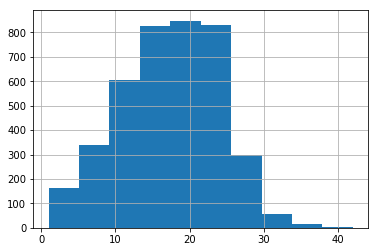

In [16]:
train.seq_len.hist()

In [17]:
train_sub, validation = model_selection.train_test_split(train, test_size = 0.2, random_state = 123)

In [18]:
class VectorizeData(Dataset):
    def __init__(self, df, label, maxlen=20):
        self.df = df
        self.label = label

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.padded_tweet[idx]
        y = self.df[self.label][idx]
        lens = self.df.seq_len[idx]
        return X,y,lens

In [19]:
train_sub.reset_index(inplace = True, drop = True)

validation.reset_index(inplace = True, drop = True)

In [20]:
data = VectorizeData(train_sub, label = 'hatespeech')

dl = DataLoader(data, batch_size = 32, shuffle = True)

In [21]:
class LSTMClassifier(nn.Module):
    def __init__(self, weights, vocab_size, embedding_dim, hidden_dim, output_size, batch_size):
        super(LSTMClassifier, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(self.weights)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)
        self.hidden2out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax()
        self.dropout_layer = nn.Dropout(p=0.2)
        self.batch_size = batch_size
    
    def init_hidden(self, batch_size):
        return(autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)), \
               autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))

    def forward(self, batch):
        self.hidden = self.init_hidden(batch_size)
        embeds = self.embedding(batch) 
        #packed_input = pack_padded_sequence(embeds, lengths)
        outputs, (ht, ct) = self.lstm(embeds, self.hidden)
        # ht is the last hidden state of the sequences
        # ht = (1 x batch_size x hidden_dim)
        # ht[-1] = (batch_size x hidden_dim)
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        output = self.softmax(output)
        return output

In [23]:
hidden_size = 200 
num_classes = 2
learning_rate = 0.001
num_epochs = 20
batch_size = 32

In [28]:
def get_validation_loss(validation_data_loader, model):
    predictions = []
    pred_labels = []
    #get training predictions
    it = iter(validation_data_loader)
    num_batch = len(validation_data_loader) - 1
    # Loop over all batches
    for i in range(num_batch):
        batch_x,batch_y,batch_len = next(it)
        tweets = Variable(batch_x.transpose(0,1))
        labels = Variable(batch_y)
        lengths = Variable(batch_len)
        outputs = model(tweets)
        _, pred = torch.max(outputs.data, 1)
        predictions.extend(list(pred.numpy()))
        pred_labels.extend(list(labels.data.numpy()))
    return (f1_score(predictions, pred_labels))

In [37]:
#net = LSTMClassifier(weights, total_words, hidden_size, hidden_size, num_classes, batch_size)
net = pickle.load(open('model_for_transfer_learning.sav', 'rb'))

In [38]:
# Loss and Optimizer
criterion = nn.NLLLoss(weight = torch.Tensor([1/39,1]))  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Validation Data
val = VectorizeData(validation, label = 'hatespeech')
dl2 = DataLoader(val, batch_size = 32, shuffle = False)

losses = []
val_scores = []

In [39]:
num_epochs = 20

num_batch = len(dl) - 1
# Train the Model
for epoch in range(num_epochs):
    it = iter(dl)
    # Loop over all batches
    for i in range(num_batch):
        batch_x,batch_y,batch_len = next(it)
        tweets = Variable(batch_x.transpose(0,1))
        labels = Variable(batch_y)
        lengths = Variable(batch_len)
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(tweets)
        loss = criterion(outputs, labels)
        losses.append(loss.data[0])
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train.clean_tweet)//batch_size, loss.data[0]))
    val_scores.append(get_validation_loss(dl2, net))
    if epoch > 5:
        if val_scores[-1] == max(val_scores):
            best_net = net

Epoch [1/20], Step [4/124], Loss: 0.2715
Epoch [1/20], Step [8/124], Loss: 0.3476
Epoch [1/20], Step [12/124], Loss: 1.1946
Epoch [1/20], Step [16/124], Loss: 0.1855
Epoch [1/20], Step [20/124], Loss: 0.7305
Epoch [1/20], Step [24/124], Loss: 1.9721
Epoch [1/20], Step [28/124], Loss: 0.3038
Epoch [1/20], Step [32/124], Loss: 0.5662
Epoch [1/20], Step [36/124], Loss: 0.4746
Epoch [1/20], Step [40/124], Loss: 0.3257
Epoch [1/20], Step [44/124], Loss: 3.1472
Epoch [1/20], Step [48/124], Loss: 0.2172
Epoch [1/20], Step [52/124], Loss: 0.5465
Epoch [1/20], Step [56/124], Loss: 0.3385
Epoch [1/20], Step [60/124], Loss: 0.3376
Epoch [1/20], Step [64/124], Loss: 0.1202
Epoch [1/20], Step [68/124], Loss: 0.4477
Epoch [1/20], Step [72/124], Loss: 0.3389
Epoch [1/20], Step [76/124], Loss: 0.2466
Epoch [1/20], Step [80/124], Loss: 0.2431
Epoch [1/20], Step [84/124], Loss: 0.3425
Epoch [1/20], Step [88/124], Loss: 0.3683
Epoch [1/20], Step [92/124], Loss: 0.2811
Epoch [1/20], Step [96/124], Loss: 0

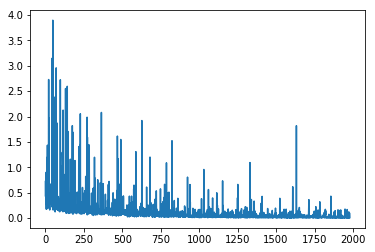

In [40]:
plt.plot(losses) #trained at lr of 0.001 for 10 epochs

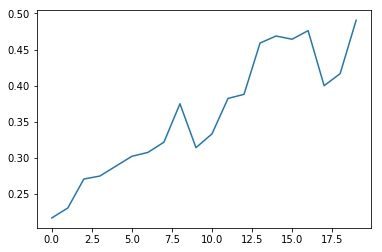

In [41]:
plt.plot(val_scores)

In [42]:
max(val_scores)

0.49056603773584906